# First Steps

In this tutorial, we'll create our first fully simulated scenario: a server connected to solar power with battery backup.

In [1]:
import vessim as vs

# For plotting results
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Required for running Mosaic in Jupyter notebooks (fixes asyncio event loop conflicts)
import nest_asyncio
nest_asyncio.apply()

We'll create a single microgrid with:

- **A server** that constantly uses 700W.
- **A solar power system** that produces up to 5kW (using real weather data provided by [Solcast](https://solcast.com).
- **A battery** that can store up to 1500Wh of energy (starts 80% charged, never goes below 30%). We use a `vs.SimpleBattery` which has no (dis)charge limits or losses.
- **A monitor** that writes all progress to a CSV file.

The simulation covers a 24 hour period in Berlin on June, 2022.

In [2]:
# Create the simulation environment
environment = vs.Environment(sim_start="2022-06-09 00:00:00")

# Logs all relevant simulation data to a CSV file
monitor = vs.Monitor(outfile="result.csv")

# Add a single microgrid to the simulation
environment.add_microgrid(
    actors=[
        # Server that consumes 700W constantly
        vs.Actor(
            name="server",
            signal=vs.ConstantSignal(value=-700),  # negative = consumes power
        ),
        # Solar panel that produces up to 5kW based on the Berlin dataset provided by Solcast
        vs.Actor(
            name="solar_panel",
            signal=vs.Trace.load(
                "solcast2022_global", 
                column="Berlin", 
                params={"scale": 5000}  # 5kW maximum
            ),
        ),
    ],
    controllers=[
        monitor
    ],
    storage=vs.SimpleBattery(
        capacity=1500,      # 1500Wh capacity
        initial_soc=0.8,    # Start 80% charged
        min_soc=0.3         # Never go below 30%
    ),
    step_size=300,  # Simulates the microgrid in 5min steps
)

# Run the simulation for 24 hours
environment.run(until=24 * 3600)

2025-06-27 13:19:30.135 | INFO     | mosaik.async_scenario:start:361 - Starting "Actor" as "server" ...
2025-06-27 13:19:30.136 | INFO     | mosaik.async_scenario:start:361 - Starting "Actor" as "solar_panel" ...
2025-06-27 13:19:30.138 | INFO     | mosaik.async_scenario:start:361 - Starting "Grid" as "Grid-0" ...
2025-06-27 13:19:30.139 | INFO     | mosaik.async_scenario:start:361 - Starting "Controller" as "Monitor-0" ...
2025-06-27 13:19:30.140 | INFO     | mosaik.async_scenario:start:361 - Starting "Storage" as "Storage-0" ...
2025-06-27 13:19:30.141 | INFO     | mosaik.async_scenario:run:697 - Starting simulation.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86400/86400 [00:00<00:00, 367187.37steps/s]
2025-06-27 13:19:30.407 | INFO     | mosaik.async_scenario:run:753 - Simulation finished successfully.


## Results

We load the results from disc and take a look at the first few rows. Alternatively, you can access the logs in-memory via `monitor.log`.

In [3]:
df = pd.read_csv("result.csv", parse_dates=[0], index_col=0)
df.head()

,p_delta,p_grid,server.p,solar_panel.p,policy.mode,policy.charge_power,storage.soc,storage.charge_level,storage.capacity,storage.min_soc,storage.c_rate
time,,,,,,,,,,,
2022-06-09 00:00:00,-700.0,0.0,-700,0.0,grid-connected,0.0,0.800000,1200.000000,1500,0.3,NaN
2022-06-09 00:05:00,-700.0,0.0,-700,0.0,grid-connected,0.0,0.761111,1141.666667,1500,0.3,NaN
2022-06-09 00:10:00,-700.0,0.0,-700,0.0,grid-connected,0.0,0.722222,1083.333333,1500,0.3,NaN
2022-06-09 00:15:00,-700.0,0.0,-700,0.0,grid-connected,0.0,0.683333,1025.000000,1500,0.3,NaN
2022-06-09 00:20:00,-700.0,0.0,-700,0.0,grid-connected,0.0,0.644444,966.666667,1500,0.3,NaN


## Visualization

The log contains metrics from all consumers, producers, the battery, and the grid.
Let's visualize the results to see the key patterns:

- **At night**: No solar power, so the battery provides power until it's depleted, then power comes from the public grid.
- **During the day**: Solar panels produce more power than the server needs, so excess energy charges the battery. Once the battery is full, energy is fed back to the public grid.
- **At evening**: Solar power decreases and the battery gets discharged.

Note:
- **Delta power** describes the sum over all actors' power (consumers and producers), so it's the current deficit or excess of electricity.
- **Grid power** describs the power that has been drawn or fed into the public grind during the last simulation step, hence, after considering the charging/discharging of batteries.

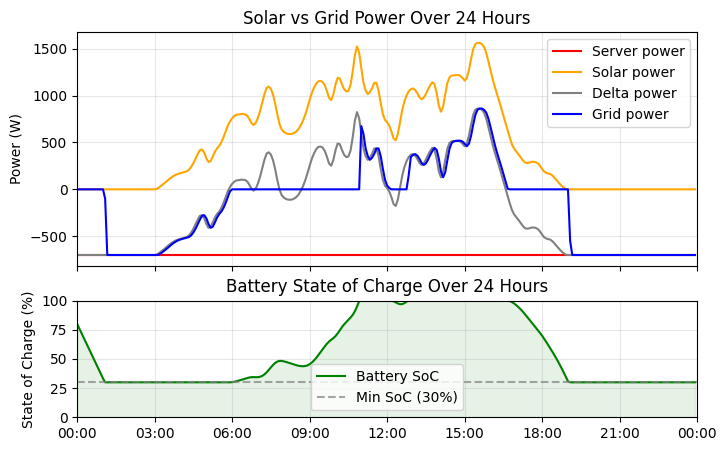

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5), height_ratios=[2, 1], sharex=True)

# Top: Solar vs Grid Power
ax1.plot(df.index, df["server.p"], color="red", label="Server power")
ax1.plot(df.index, df["solar_panel.p"], color="orange", label="Solar power")
ax1.plot(df.index, df["p_delta"], color="gray", label="Delta power")
ax1.plot(df.index, df["p_grid"], color="blue", label="Grid power")

ax1.grid(True, alpha=0.3)
ax1.set_ylabel("Power (W)")
ax1.set_title("Solar vs Grid Power Over 24 Hours")
ax1.legend()

# Bottom: Battery State of Charge
ax2.plot(df.index, df["storage.soc"] * 100, color="green", label="Battery SoC")
ax2.fill_between(df.index, df["storage.soc"] * 100, color="green", alpha=0.1)
ax2.axhline(y=30, color='gray', linestyle='--', alpha=0.7, label="Min SoC (30%)")

ax2.grid(True, alpha=0.3)
ax2.set_ylabel("State of Charge (%)")
ax2.set_title("Battery State of Charge Over 24 Hours")
ax2.set_ylim(0, 100)
ax2.legend()

# Format the x-axis for both subplots
ax2.set_xlim(pd.to_datetime("2022-06-09 00:00:00"), pd.to_datetime("2022-06-10 00:00:00"))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

plt.show()